# Predicción del abandono (burnout) de empleados en una empresa

## Configuraciones iniciales 

In [4]:
# Importaciones necesarias para el desarrollo de la practica

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Constantes usadas durante el desarrollo de la practica
                    
SEED = 100475757 # La semilla es el NIA 
employees_ava = pd.read_csv("DATA/employee_availabledata.csv", index_col= 0)
employees_comp = pd.read_csv("DATA/employee_competition.csv", index_col= 0) # Mostrar las primeras filas del DataFrame

## EDA 

Antes de nada, voy a comenzar con un análisis de la database para entender mejor la estructura que sigue. Se presentan las siguientes acciones:

1. **Visualización de las primeras filas:** Para obtener una idea general de la estructura del dataset.
2. **Tipos de datos por columna:** Para identificar si las variables son categóricas, numéricas o de otro tipo.
3. **Valores nulos:** Para analizar la cantidad de valores faltantes en cada columna.
4. **Columnas con valores únicos:** Para detectar variables que tienen un solo valor en todo el conjunto de datos, lo que puede indicar redundancia.



In [3]:
# Mostrar las primeras filas del DataFrame
print("Primeras filas:")
display(employees_ava.head())

# Mostrar los tipos de datos de cada columna
print("\nTIPOS DE DATOS:")
print(employees_ava.dtypes)

# Contar los valores nulos en cada columna y mostrarlos
print("\nVALORES NULOS POR COLUMNA:")
display(employees_ava.isnull().sum())

# Encontrar columnas que solo tienen un valor único y mostrarlas
unique_columns = employees_ava.columns[employees_ava.nunique() == 1].tolist()
print("\nColumnas con valores únicos:")
print(unique_columns)

employees_ava.info() 

Primeras filas:


,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,DistanceFromHome,...,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
hrs,,,,,,,,,,,,,,,,,,,,,
6.711397,17,2,3,3.0,3.0,4.0,45,Non-Travel,Sales,1,...,Y,15,8,0,10.0,3,8,5,7,No
6.433872,13,3,3,3.0,3.0,3.0,30,Travel_Rarely,Research & Development,2,...,Y,18,8,1,10.0,3,7,1,7,No
8.590515,15,3,3,4.0,3.0,3.0,43,Travel_Frequently,Sales,4,...,Y,11,8,1,10.0,5,8,4,7,No
6.888548,21,3,4,4.0,3.0,3.0,26,Travel_Rarely,Research & Development,11,...,Y,20,8,0,5.0,3,4,0,0,No
6.308825,11,3,3,2.0,1.0,2.0,42,Travel_Rarely,Research & Development,7,...,Y,11,8,0,10.0,2,0,0,0,No



TIPOS DE DATOS:
absences                     int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                          int64
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeID                   int64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome                int64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
Yea

absences                    0
JobInvolvement              0
PerformanceRating           0
EnvironmentSatisfaction    18
JobSatisfaction            14
WorkLifeBalance            20
Age                         0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         10
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
Attrition                   0
dtype: int64


Columnas con valores únicos:
['EmployeeCount', 'Over18', 'StandardHours']
<class 'pandas.core.frame.DataFrame'>
Index: 2940 entries, 6.7113966979025 to 8.027183177153056
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   absences                 2940 non-null   int64  
 1   JobInvolvement           2940 non-null   int64  
 2   PerformanceRating        2940 non-null   int64  
 3   EnvironmentSatisfaction  2922 non-null   float64
 4   JobSatisfaction          2926 non-null   float64
 5   WorkLifeBalance          2920 non-null   float64
 6   Age                      2940 non-null   int64  
 7   BusinessTravel           2940 non-null   object 
 8   Department               2940 non-null   object 
 9   DistanceFromHome         2940 non-null   int64  
 10  Education                2940 non-null   int64  
 11  EducationField           2940 non-null   object 
 12  EmployeeCount            2940 non-n

Como se puede observar, existen varias columnas de la base de datos con valores nulos y algunas con un valor único en todas las filas, las cuales podrian no aportar información relevante. Además, las variables categóricas necesitarán ser codificadas en formato numérico para su correcto procesamiento. 

## Análisis de la Variable Objetivo "Attrition"

También voy a realizar un análisis de la variable objetivo "Attrition" para entender mejor su distribución en el conjunto de datos. La variable "Attrition" indica si un empleado ha dejado la empresa (yes) o no (no). Para ello, he querido realizar lo siguiente: 

1. **Contar el número de empleados en cada categoría y calcular el porcentaje correspondiente.**

2. **Mostrar un DataFrame con el conteo y el porcentaje de empleados que han dejado la empresa y los que no.**

3. **Crear un gráfico de barras para visualizar la distribución de "Attrition".**


,Count,Percentage
Attrition,,
No,2466,83.877551
Yes,474,16.122449


/tmp/ipykernel_5075/4094295936.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attrition_counts.index, y=attrition_counts.values, palette="Blues")


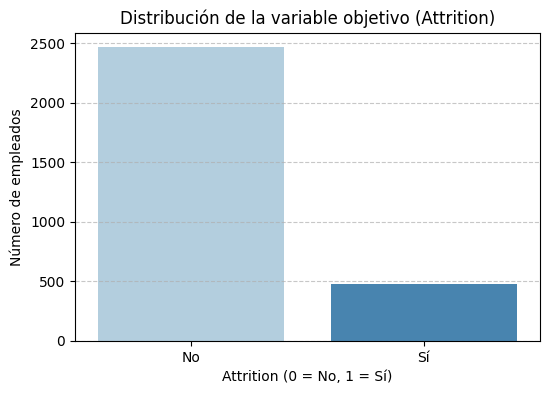

In [5]:
# Análisis de la variable objetivo "Attrition"
attrition_counts = employees_ava["Attrition"].value_counts()
attrition_percentage = employees_ava["Attrition"].value_counts(normalize=True) * 100

# Mostrar los valores y porcentajes en un DataFrame
attrition_summary = pd.DataFrame({"Count": attrition_counts, "Percentage": attrition_percentage})
display(attrition_summary)

# Visualización de la distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.barplot(x=attrition_counts.index, y=attrition_counts.values, palette="Blues")
plt.title("Distribución de la variable objetivo (Attrition)")
plt.xlabel("Attrition (0 = No, 1 = Sí)")
plt.ylabel("Número de empleados")
plt.xticks([0,1], ["No", "Sí"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

La variable objetivo 'Attrition' presenta un claro desbalance, con un 83.88% de empleados que no han abandonado frente a un 16.12% que sí. Este desequilibrio podría influir en el rendimiento del modelo, favoreciendo la predicción de la clase mayoritaria y dificultando la detección de los casos de abandono.